# 3. Estadísticas univariadas categóricas

In [19]:
%pip install -e ..
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from IPython.display import display
from pandas.api.types import is_numeric_dtype
from tqdm.auto import tqdm

from functions import load_csv
from functions.fen_analyzer import (
    extract_active_turn,
    extract_castling_rights,
    extract_bishop_parity,
    extract_queen_presence,
)

Obtaining file:///C:/Users/samir/Documents/noveno%20semestre/aprendizaje%20maquina/stocksalmon
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for stocksalmon (pyproject.toml): started
  Building editable for stocksalmon (pyproject.toml): finished with status 'done'
  Created wheel for stocksalmon: filename=stocksalmon-0.1.0-0.editable-py3-none-any.whl size=2804 sha256=9bdeff72bd3a7b508b18c703c957c625cae0cb0e19ecbaa48c3c3b910ca219cf
  Stored in directory: C:\Users\samir\AppData\Local\Temp\pip-ephem-wheel-cache-wnaebkqa\wheels\


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Configuración rápida del análisis (ajustable)
N_SAMPLE = 100              # filas a leer del CSV para EDA rápida
USE_FULL_DATA = True       # si True, ignora N_SAMPLE y carga todo
MAX_CARD_AS_CAT = 100       # numéricas con <=100 únicos se tratan como categóricas
MAX_UNIQUE_RATIO = 0.50     # descarta columnas con >50% de valores únicos (ID-like)
TOP_K = 20                  # Top categorías a mostrar en tablas/plots
MIN_FREQ_PLOT = 2           # frecuencia mínima para dibujar en barras
ENABLE_BISHOP_PARITY = False  # calcula paridad de alfiles (costoso)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 120)

In [21]:
def get_categorical_columns(
    df: pd.DataFrame,
    max_card_as_cat: int = 200,
    max_unique_ratio: float = 0.50
):
    """
    Devuelve columnas categóricas (object/string/category/bool) + numéricas discretas con poca cardinalidad.
    - max_card_as_cat: si una numérica tiene <= ese número de únicos, la tratamos como categórica (discreta).
    - max_unique_ratio: descarta columnas con un % muy alto de valores únicos (ID-like).
    """
    n = len(df)
    cat_like = df.select_dtypes(include=["object", "string", "category", "bool"]).columns.tolist()
    numeric_low_card = []
    for c in df.select_dtypes(include=[np.number]).columns:
        nunq = df[c].nunique(dropna=True)
        if nunq <= max_card_as_cat:
            numeric_low_card.append(c)
    seen, result = set(), []
    for c in cat_like + numeric_low_card:
        if c in seen:
            continue
        seen.add(c)
        nunq = df[c].nunique(dropna=True)
        ratio = nunq / max(1, n)
        if ratio <= max_unique_ratio:
            result.append(c)
    return result

def summarize_categoricals(df: pd.DataFrame, cols=None, topn_mode: int = 1):
    """
    Retorna un DataFrame con: dtype, n_unique, %_unique, n_missing, %_missing, mode, mode_freq.
    """
    if cols is None:
        cols = get_categorical_columns(df)
    rows = []
    n = len(df)
    for c in cols:
        ser = df[c]
        nunq = ser.nunique(dropna=True)
        nmiss = ser.isna().sum()
        vc = ser.value_counts(dropna=True)
        if len(vc) > 0:
            moda = ", ".join([f"{idx}" for idx in vc.index[:topn_mode]])
            moda_freq = float((vc.iloc[0] / (n - nmiss)).round(4))
        else:
            moda, moda_freq = None, np.nan
        rows.append({
            "col": c,
            "dtype": str(ser.dtype),
            "n_unique": nunq,
            "%_unique": round(100 * nunq / max(1, n - nmiss), 2),
            "n_missing": int(nmiss),
            "%_missing": round(100 * nmiss / n, 2),
            "mode": moda,
            "mode_freq": moda_freq,
        })
    out = pd.DataFrame(rows)
    if out.empty:
        return out
    return out.set_index("col").sort_values(["%_missing", "%_unique"], ascending=[False, False])

def analyze_categorical(df: pd.DataFrame, col: str, target: str | None = None, top_k: int = 20, min_freq_plot: int = 1):
    # Nombres amigables para títulos
    friendly = {
        'side_to_move': 'Turno al mover',
        'castling_state': 'Estado de enroques',
        'ep_available': 'En passant disponible',
        'has_w_queen': 'Dama blanca presente',
        'has_b_queen': 'Dama negra presente',
        'has_any_queen': 'Alguna dama presente',
    }
    col_title = friendly.get(col, col)

    ser = df[col]
    n_total = len(ser)
    n_missing = int(ser.isna().sum())
    vc_nonan = ser.value_counts(dropna=True)

    # Tabla de frecuencias (Top-K)
    freq_tbl = pd.DataFrame({"Conteo": vc_nonan, "Porcentaje": (vc_nonan / vc_nonan.sum() * 100).round(2)})
    print(f'Frecuencias de {col_title} (Top {min(top_k, len(freq_tbl))}) — n={n_total}, faltantes={n_missing}')
    display(freq_tbl.head(top_k))

    # Gráfico de barras (Top-K)
    vc_plot = vc_nonan[vc_nonan >= min_freq_plot].head(top_k)
    plt.figure(figsize=(9, 4))
    vc_plot.sort_values(ascending=True).plot(kind="barh")
    plt.title(f"{col_title} — Top {len(vc_plot)} categorías")
    plt.xlabel("Conteo")
    plt.ylabel("Categoría")
    plt.tight_layout()
    plt.show()

    # Resumen por categoría del target numérico (si aplica)
    if target is not None and target in df.columns and is_numeric_dtype(df[target]):
        # Copia + sanea el target
        tmp = df[[col, target]].copy()
        tmp[target] = pd.to_numeric(tmp[target], errors='coerce')
        tmp.replace([np.inf, -np.inf], np.nan, inplace=True)
        tmp.dropna(subset=[target], inplace=True)

        # Top-K categorías tras limpieza (asegura datos en cada categoría)
        present_cats = tmp[col].value_counts(dropna=False).index[:top_k]
        tmp = tmp[tmp[col].isin(present_cats)]

        grp = (
            tmp.groupby(col, observed=True)[target]
               .agg(['count', 'mean', 'median', 'std'])
               .sort_values('count', ascending=False)
        ).rename(columns={'count': 'conteo', 'mean': 'media', 'median': 'mediana', 'std': 'desv_std'})
        print(f'Resumen de {target} por {col_title} (Top {len(grp)})')
        display(grp)

        # Boxplot robusto del target por categoría (Top-K)
        cats = grp.index.tolist()
        if len(cats) >= 2:
            data = [tmp.loc[tmp[col].eq(cat), target].to_numpy() for cat in cats]
            labels = [str(cat) for cat in cats]
            plt.figure(figsize=(10, 4))
            plt.boxplot(data, labels=labels, showfliers=False)
            plt.xticks(rotation=45)
            plt.title(f"{target} por {col_title} (Top {len(labels)})")
            plt.tight_layout()
            plt.show()
        else:
            print('No hay suficientes categorías con datos del target para graficar.')


In [22]:
DATA_DIR = Path("../data/raw")
df_chess = load_csv(DATA_DIR / "chessData.csv", nrows=(None if USE_FULL_DATA else N_SAMPLE))
df_chess = df_chess.rename(columns={"FEN": "fen", "Evaluation": "evaluation"})
if "evaluation" in df_chess.columns:
    df_chess["evaluation"] = pd.to_numeric(df_chess["evaluation"], errors="coerce").astype('float64')
display(pd.DataFrame({'col': df_chess.columns, 'dtype': [str(t) for t in df_chess.dtypes]}).set_index('col'))
print('shape:', df_chess.shape)
display(df_chess.head())

,dtype
col,
fen,string[pyarrow]
evaluation,float64


shape: (12958035, 2)


,fen,evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1,-10.0
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2,56.0
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2,-9.0
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 0 3,52.0
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQKBNR b KQkq - 1 3,-26.0


In [23]:
# UVA directo sobre columnas categóricas 
cat_cols = get_categorical_columns(df_chess, max_card_as_cat=MAX_CARD_AS_CAT, max_unique_ratio=MAX_UNIQUE_RATIO)
summary = summarize_categoricals(df_chess, cols=cat_cols)
if len(summary) > 0:
    print('Resumen de columnas categóricas detectadas (Top 30 por % faltantes/% únicos)')
    display(summary.head(30))
else:
    print('No se detectaron columnas categóricas tras los filtros.')
    # Diagnóstico rápido de unicidad/faltantes por columna
    cand = []
    n = len(df_chess)
    for c in df_chess.columns:
        ser = df_chess[c]
        nunq = ser.nunique(dropna=True)
        miss = ser.isna().sum()
        pctu = round(100 * nunq / max(1, n - miss), 2)
        cand.append({'col': c, 'dtype': str(ser.dtype), '%_unique': pctu, '%_missing': round(100*miss/n, 2)})
    diag = pd.DataFrame(cand).sort_values('%_unique', ascending=False)
    display(diag)

cols_to_plot = summary.index.tolist() if len(summary) else []
TARGET_COL = 'evaluation'
if len(cols_to_plot) == 0:
    print("No hay columnas para graficar (cardinalidad muy alta).")
else:
    for c in cols_to_plot:
        print('='*100)
        print(f'🔹 {c}')
        analyze_categorical(df_chess, c, target=TARGET_COL, top_k=TOP_K, min_freq_plot=MIN_FREQ_PLOT)


No se detectaron columnas categóricas tras los filtros.


,col,dtype,%_unique,%_missing
0,fen,string[pyarrow],99.98,0.00
1,evaluation,float64,0.11,1.47


No hay columnas para graficar (cardinalidad muy alta).


Resumen de columnas FEN derivadas (categóricas):


,dtype,n_unique,%_unique,n_missing,%_missing,mode,mode_freq
col,,,,,,,
side_to_move,object,2,0.0,0,0.0,black,0.5004
castling_state,category,4,0.0,0,0.0,none,0.9119
ep_available,boolean,2,0.0,0,0.0,False,0.9984
has_w_queen,boolean,2,0.0,0,0.0,True,0.6300
has_b_queen,boolean,2,0.0,0,0.0,True,0.6261
has_any_queen,boolean,2,0.0,0,0.0,True,0.6445


  0%|          | 0/6 [00:00<?, ?it/s]

🔹 side_to_move
Frecuencias de Turno al mover (Top 2) — n=12958035, faltantes=0


,Conteo,Porcentaje
side_to_move,,
black,6484130,50.04
white,6473905,49.96


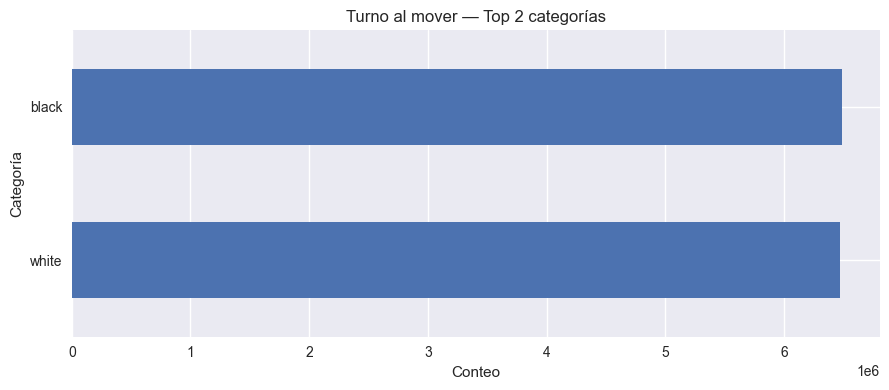

Resumen de evaluation por Turno al mover (Top 2)


,conteo,media,mediana,desv_std
side_to_move,,,,
black,6388746,29.806742,0.0,818.405862
white,6379135,61.230151,49.0,809.029674


C:\Users\samir\AppData\Local\Temp\ipykernel_7508\1138255799.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


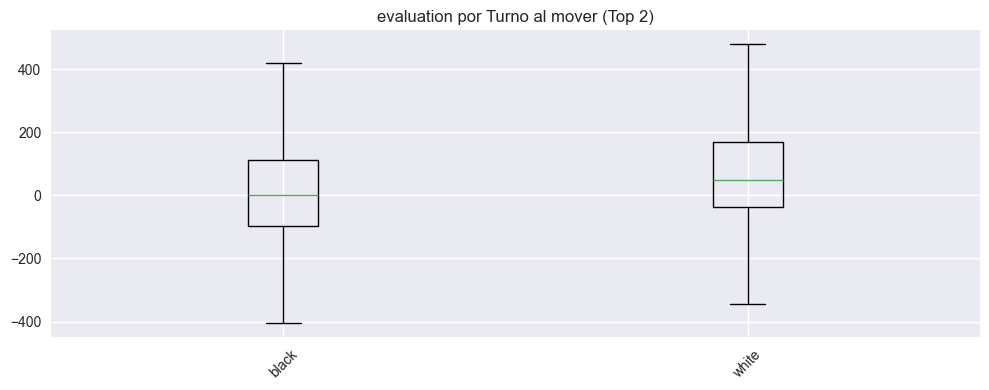

 17%|█▋        | 1/6 [00:04<00:23,  4.73s/it]

🔹 castling_state
Frecuencias de Estado de enroques (Top 4) — n=12958035, faltantes=0


,Conteo,Porcentaje
castling_state,,
none,11816449,91.19
black_only,432278,3.34
both,360032,2.78
white_only,349276,2.70


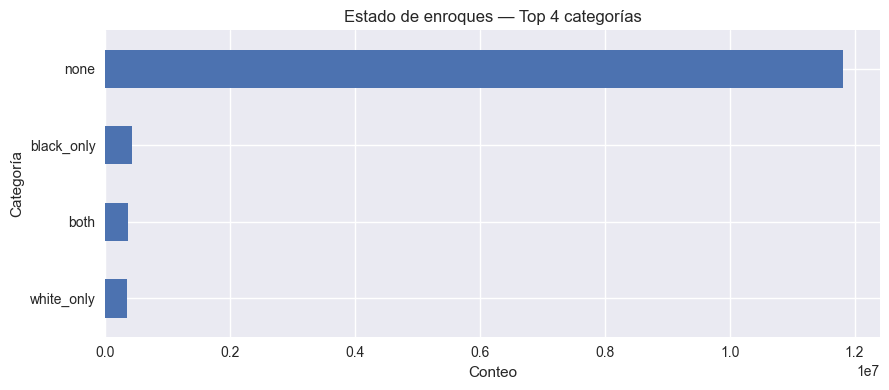

Resumen de evaluation por Estado de enroques (Top 4)


,conteo,media,mediana,desv_std
castling_state,,,,
none,11628772,46.885791,13.0,849.692598
black_only,431052,37.317189,24.0,265.807614
both,359916,29.064368,25.0,151.011327
white_only,348141,26.577022,24.0,256.688785


C:\Users\samir\AppData\Local\Temp\ipykernel_7508\1138255799.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


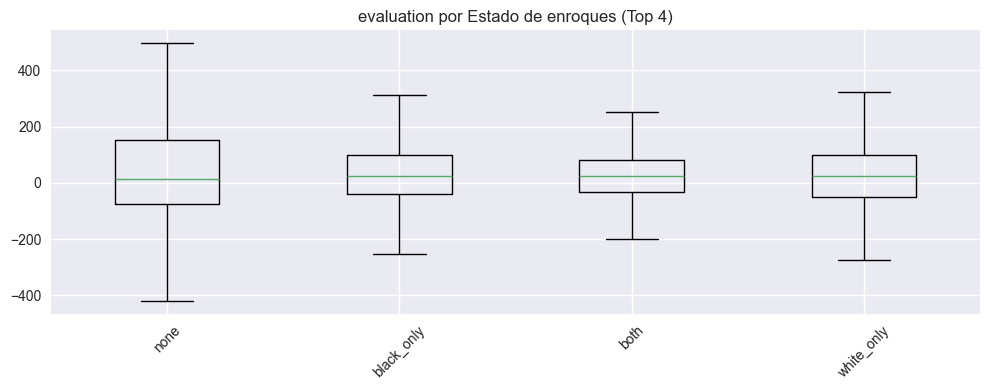

 33%|███▎      | 2/6 [00:06<00:11,  2.83s/it]

🔹 ep_available
Frecuencias de En passant disponible (Top 2) — n=12958035, faltantes=0


,Conteo,Porcentaje
ep_available,,
False,12937295,99.84
True,20740,0.16


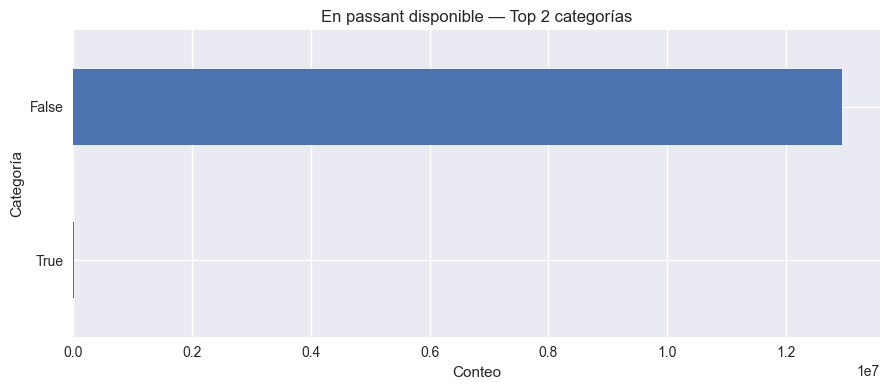

Resumen de evaluation por En passant disponible (Top 2)


,conteo,media,mediana,desv_std
ep_available,,,,
False,12747301,45.437952,15.0,814.303994
True,20580,88.039456,74.0,489.390317


C:\Users\samir\AppData\Local\Temp\ipykernel_7508\1138255799.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


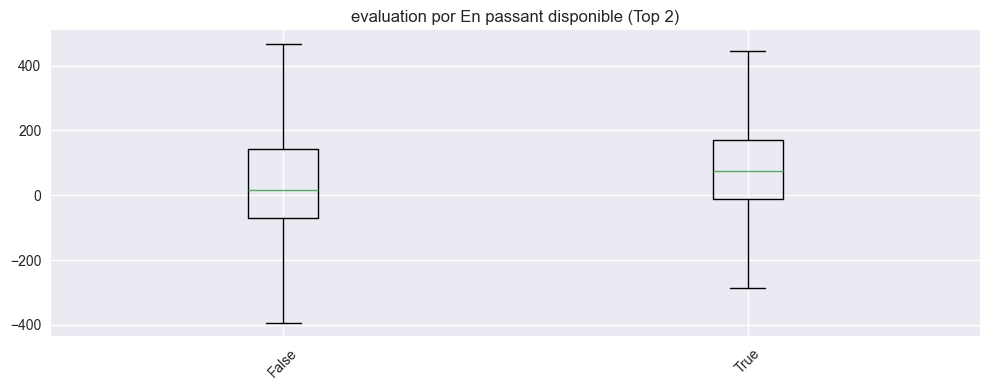

 50%|█████     | 3/6 [00:07<00:06,  2.22s/it]

🔹 has_w_queen
Frecuencias de Dama blanca presente (Top 2) — n=12958035, faltantes=0


,Conteo,Porcentaje
has_w_queen,,
True,8164049,63.0
False,4793986,37.0


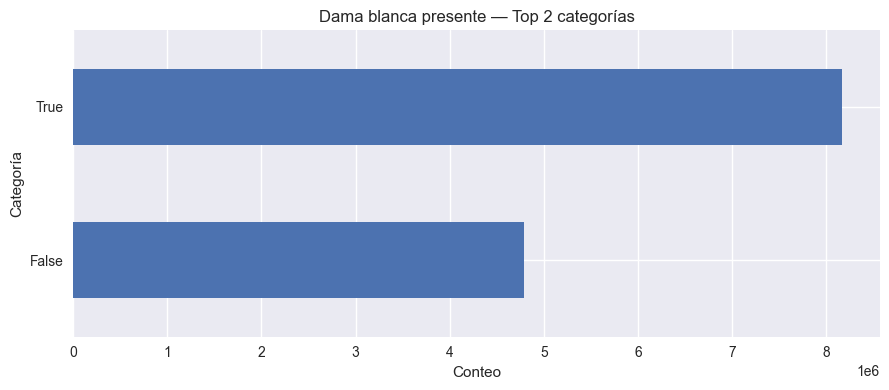

Resumen de evaluation por Dama blanca presente (Top 2)


,conteo,media,mediana,desv_std
has_w_queen,,,,
True,8044603,60.273405,29.0,619.343417
False,4723278,20.356094,0.0,1065.972288


C:\Users\samir\AppData\Local\Temp\ipykernel_7508\1138255799.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


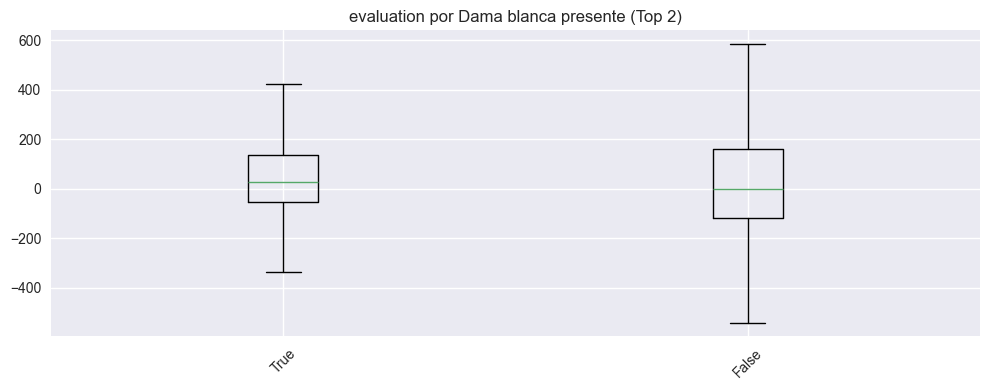

 67%|██████▋   | 4/6 [00:09<00:03,  1.96s/it]

🔹 has_b_queen
Frecuencias de Dama negra presente (Top 2) — n=12958035, faltantes=0


,Conteo,Porcentaje
has_b_queen,,
True,8112854,62.61
False,4845181,37.39


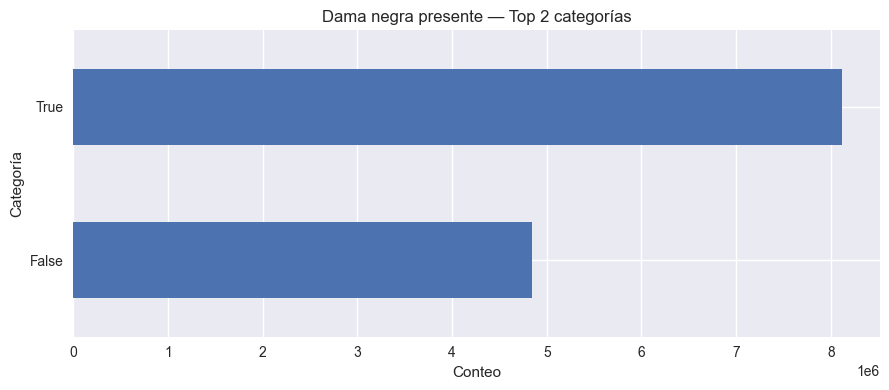

Resumen de evaluation por Dama negra presente (Top 2)


,conteo,media,mediana,desv_std
has_b_queen,,,,
True,7996324,40.965398,25.0,613.318768
False,4771557,53.116940,0.0,1068.656895


C:\Users\samir\AppData\Local\Temp\ipykernel_7508\1138255799.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


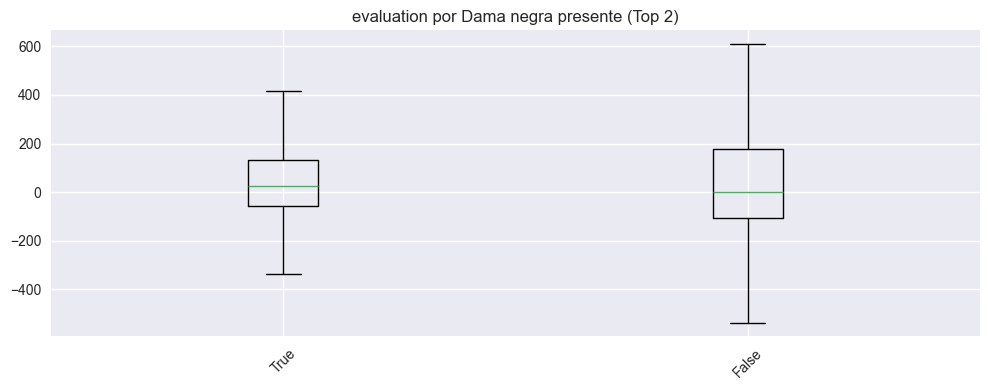

 83%|████████▎ | 5/6 [00:10<00:01,  1.81s/it]

🔹 has_any_queen
Frecuencias de Alguna dama presente (Top 2) — n=12958035, faltantes=0


,Conteo,Porcentaje
has_any_queen,,
True,8351434,64.45
False,4606601,35.55


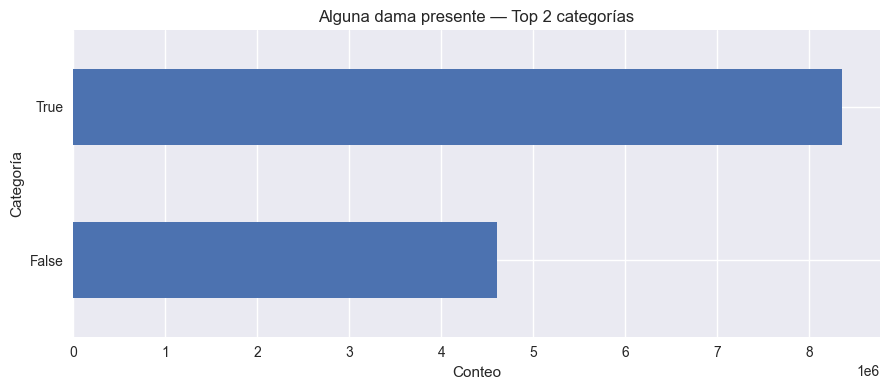

Resumen de evaluation por Alguna dama presente (Top 2)


,conteo,media,mediana,desv_std
has_any_queen,,,,
True,8215701,51.482575,27.0,648.782757
False,4552180,34.721311,0.0,1047.889084


C:\Users\samir\AppData\Local\Temp\ipykernel_7508\1138255799.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


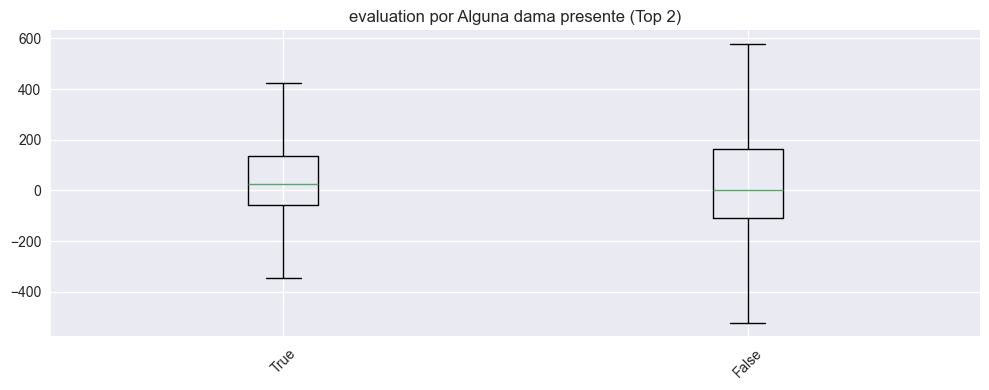

100%|██████████| 6/6 [00:12<00:00,  2.07s/it]
C:\Users\samir\AppData\Local\Temp\ipykernel_7508\209905380.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_for_uva.pivot_table(index='side_to_move', columns='castling_state', values='evaluation', aggfunc='mean')


Media de evaluation por Turno al mover × Estado de enroques


castling_state,black_only,both,none,white_only
side_to_move,,,,
black,3.32,-7.75,33.20,-13.47
white,78.22,65.57,60.58,59.45


In [24]:
# Features categóricas derivadas desde FEN y análisis respecto a evaluation
fen_series = df_chess['fen'].astype('string')
feat = pd.DataFrame(index=df_chess.index)
feat['side_to_move'] = extract_active_turn(fen_series)
cast = extract_castling_rights(fen_series)
queens = extract_queen_presence(fen_series)
# Paridad de alfiles es costosa; activarla solo si ENABLE_BISHOP_PARITY=True
if ENABLE_BISHOP_PARITY:
    bishp = extract_bishop_parity(fen_series)
    feat = pd.concat([feat, cast[['castling_state','ep_available']], queens[['has_w_queen','has_b_queen','has_any_queen']], bishp[['w_bishops_colors','b_bishops_colors','bishops_parity']]], axis=1)
else:
    feat = pd.concat([feat, cast[['castling_state','ep_available']], queens[['has_w_queen','has_b_queen','has_any_queen']]], axis=1)

print('Resumen de columnas FEN derivadas (categóricas):')
display(summarize_categoricals(feat))

# Relación con evaluation
df_for_uva = pd.concat([feat, df_chess[['evaluation']]], axis=1)
cols_analisis = ['side_to_move','castling_state','ep_available','has_w_queen','has_b_queen','has_any_queen']
if ENABLE_BISHOP_PARITY:
    cols_analisis += ['w_bishops_colors','b_bishops_colors','bishops_parity']
for c in tqdm(cols_analisis, total=len(cols_analisis)):
    print('='*100)
    print(f'🔹 {c}')
    analyze_categorical(df_for_uva, c, target='evaluation', top_k=TOP_K, min_freq_plot=MIN_FREQ_PLOT)

# Vista de interacción simple: lado al turno × estado de enroque (media de evaluation)
pivot = df_for_uva.pivot_table(index='side_to_move', columns='castling_state', values='evaluation', aggfunc='mean')
print('Media de evaluation por Turno al mover × Estado de enroques')
display(pivot.round(2))
